### Preprocessing con sostituzione dei valori nan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import requests

In [2]:
# URL completi dei file nel repository GitHub
thca_url = '../data/new_tcha_dataset.csv'
lusc_url = '../data/new_lusc_dataset.csv'
skcm_url = '../data/new_skcm_dataset.csv'
coadread_url = '../data/new_coadread_dataset.csv'

In [3]:
def checkNaN(row):
    tmp_idx = -1
    tmp_values = []
    
    for i, value in enumerate(row[1:], start=1):
        
        if pd.isna(value):
            if tmp_idx != -1:
                return pd.Series([None]*len(row), index=row.index)
            else:
                tmp_idx = i
        else:
            tmp_values.append(value)
    
    if tmp_idx != -1:
        row.iloc[tmp_idx] = np.mean(tmp_values)
                
    return row

In [4]:
def processing_ds(ds_url):
    #s = requests.get(ds_url).content
    #ds = pd.read_csv(io.StringIO(s.decode('utf-8')), sep='\t')
    ds = pd.read_csv(ds_url)
    
    #ds = ds.drop(columns='Hugo_Symbol', axis=1)
   # ds = ds[:10000]  # per fare prove 
    
    ds = ds.apply(checkNaN, axis=1) # Applica la funzione a ogni *riga* del df
    ds.dropna(inplace=True)
    
    file_name = ds_url.split('/')[-1].split('.')[0]       # nome del file dall'URL
    ds.to_csv(f'../data/clean_{file_name}.csv', index=False)

    # Verifica se il df contiene valori NaN lungo le righe
    if ds.isnull().any(axis=1).any():
        print("Il dataframe contiene valori NaN lungo le righe.")

    # Elimina geni che hnno lo stesso ID
    if ds.duplicated(subset=['Entrez_Gene_Id']).sum() > 0:
        ds = ds.drop_duplicates(subset=['Entrez_Gene_Id'])

    ds.reset_index(drop=True, inplace=True)

    return ds

In [5]:
ds_thca = processing_ds(thca_url)

In [6]:
ds_lusc = processing_ds(lusc_url)

In [7]:
ds_lusc

,Entrez_Gene_Id,TCGA-21-5787-01,TCGA-34-2596-01,TCGA-34-5231-01,TCGA-37-4141-01,TCGA-39-5031-01,TCGA-43-A475-01,TCGA-63-5128-01,TCGA-68-A59J-01,TCGA-77-A5G3-01,TCGA-90-A4ED-01,TCGA-98-A53B-01
0,100130426.0,-4.8669,-4.8669,-1.4109,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669,-4.8669
1,100133144.0,-2.2769,-1.8432,0.9940,-0.0427,-0.6309,0.1270,0.9573,-0.0815,0.9524,0.8139,1.1773
2,100134869.0,-3.7670,-0.8027,0.6230,-0.1083,-0.0303,1.5171,0.4976,0.4431,0.2772,1.2035,1.6293
3,10357.0,-0.3575,-0.0693,-0.1670,1.5169,0.6871,-0.7620,-0.2407,0.0809,-0.1153,-0.3154,-0.6674
4,10431.0,2.1348,-0.4077,-0.0961,1.0508,-0.2250,-0.3290,-1.5327,-0.6485,0.1850,-1.0397,0.4995
...,...,...,...,...,...,...,...,...,...,...,...,...
20154,440590.0,0.3692,-1.6668,1.5931,1.5153,0.2441,-0.7745,-1.1293,0.5757,-0.0476,-0.6978,1.3848
20155,79699.0,-0.8104,0.6687,-0.1428,2.0329,1.0363,0.4512,0.0132,-0.2863,-0.1129,1.1434,0.2823
20156,7791.0,2.1964,-0.2895,-0.7529,-1.5565,-0.2619,-0.6951,-0.2102,-0.7775,0.1356,0.1144,0.2188
20157,23140.0,-0.3439,0.9523,-0.2842,-1.8241,-0.7941,0.4773,1.0385,0.7400,-0.1761,1.1394,0.7701


In [8]:
ds_skcm = processing_ds(skcm_url)

In [9]:
ds_coadread = processing_ds(coadread_url)

### Correlation matrix per eliminaregeni con correlazione superiore a 0.9


In [10]:
def corr_matrix(ds):
    ds.set_index('Entrez_Gene_Id', inplace=True)
    
    # Calcola la matrice di correlazione tra i geni
    corr_matrix = ds.T.corr()

    return corr_matrix

In [11]:
def delete_rows(df, valori_da_eliminare):
    print("Numero geni da togliere:" , len(valori_da_eliminare))
    print("Lunghezza database prima di togliere geni:" , len(df))    
    df.reset_index(inplace=True)

    #x = ~df['Entrez_Gene_Id'].isin(valori_da_eliminare)
    #print(len(x))
    #print(x)
    
    # Filtrare il DataFrame per eliminare le righe con i valori specificati in 'entrez'
    df = df[~df['Entrez_Gene_Id'].isin(valori_da_eliminare)]

    print("Lunghezza database dopo aver tolto i geni:" , len(df)) 
    
    return df



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_genes(ds, threshold, percentile=40):
    cm = corr_matrix(ds)  # Assuming corr_matrix is defined elsewhere

    # Creiamo una copia della matrice di correlazione per lavorare sui valori
    significant_corr = cm.copy()

    # Imposta la diagonale su un valore non significativo per ignorarla
    np.fill_diagonal(significant_corr.values, 0)

    # Convertiamo la matrice in un DataFrame lungo (melted)
    melted_correlation = significant_corr.reset_index().melt(id_vars='Entrez_Gene_Id')

    # Filtriamo solo le coppie con un valore di correlazione maggiore della soglia
    filtered_pairs = melted_correlation[(melted_correlation['value'] > threshold) | (melted_correlation['value'] < -threshold)]

    # Rinominiamo le colonne per chiarezza
    filtered_pairs.columns = ['Gene1', 'Gene2', 'Correlation']

    # Combinare Gene1 e Gene2 in un'unica serie e contare le frequenze
    all_genes = pd.concat([filtered_pairs['Gene1'], filtered_pairs['Gene2']])
    gene_counts = all_genes.value_counts()

    # Calcola il numero di geni che rappresentano il 40% più frequente
    top_genes_number = int(len(gene_counts) * (percentile / 100))

    # Seleziona il top 40% dei geni in base alla loro frequenza
    top_genes = gene_counts.nlargest(top_genes_number)

    # Creiamo il grafico delle frequenze dei geni selezionati
    plt.figure(figsize=(10, 6))
    top_genes.plot(kind='bar')
    plt.xlabel('Genes')
    plt.ylabel('Frequency')
    plt.title('Top 40% Distribution of Gene Frequencies in Filtered Pairs')
    plt.xticks(rotation=90)
    plt.show()

    # Prendere tutti i geni che sono nel top 40% e metterli in una lista
    genes_above_threshold = top_genes.index.tolist()

    ds = delete_rows(ds, genes_above_threshold)  # Assuming delete_rows is defined elsewhere
    
    return ds

In [13]:
threshold = 0.9

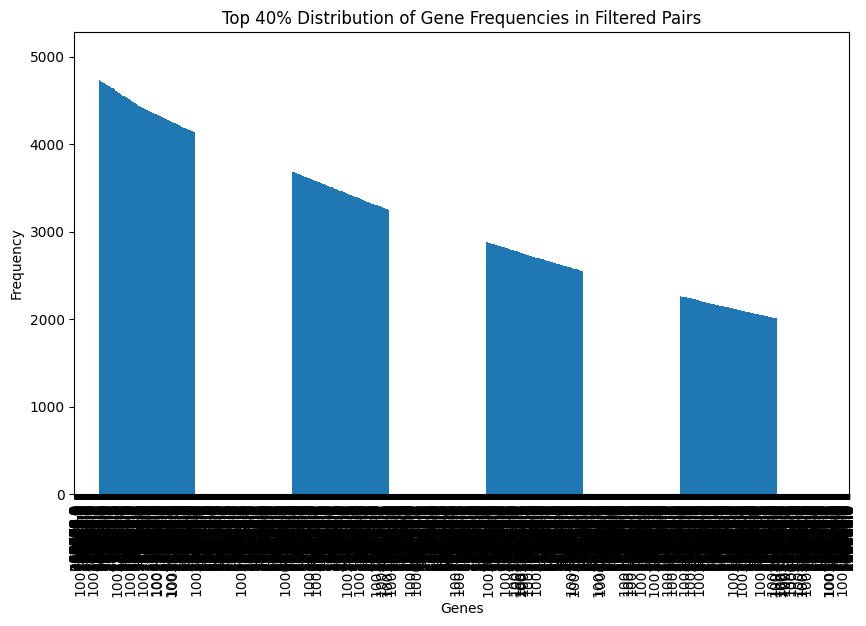

Numero geni da togliere: 6971
Lunghezza database prima di togliere geni: 17487
Lunghezza database dopo aver tolto i geni: 10516


In [14]:
ds_coadread = remove_genes(ds_coadread, threshold)

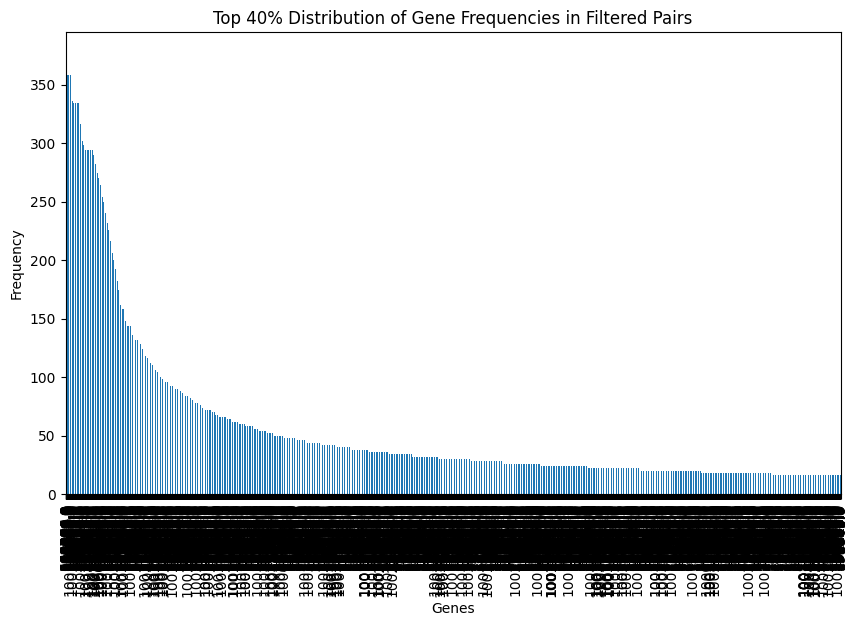

Numero geni da togliere: 7439
Lunghezza database prima di togliere geni: 20159
Lunghezza database dopo aver tolto i geni: 12720


In [15]:
ds_lusc = remove_genes(ds_lusc, threshold)


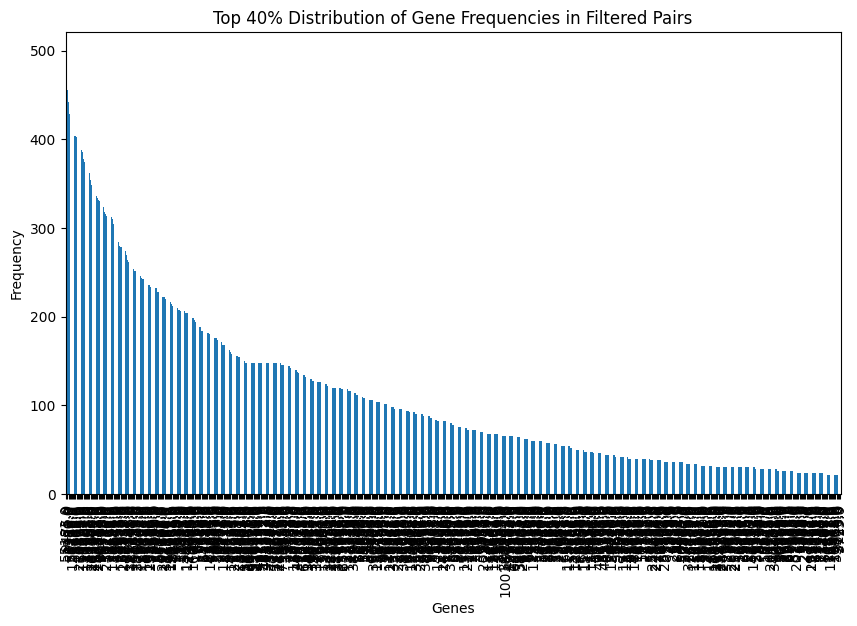

Numero geni da togliere: 670
Lunghezza database prima di togliere geni: 20023
Lunghezza database dopo aver tolto i geni: 19353


/tmp/ipykernel_8305/726780717.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


In [16]:
ds_thca = remove_genes(ds_thca, threshold)

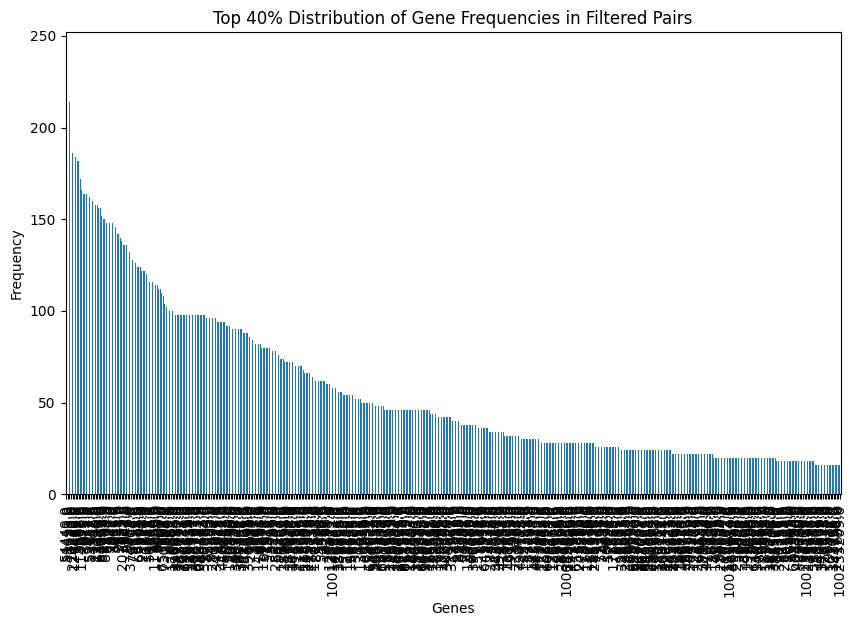

Numero geni da togliere: 504
Lunghezza database prima di togliere geni: 20151
Lunghezza database dopo aver tolto i geni: 19647


In [17]:
ds_skcm = remove_genes(ds_skcm, threshold)

In [18]:
ds_lusc

,Entrez_Gene_Id,TCGA-21-5787-01,TCGA-34-2596-01,TCGA-34-5231-01,TCGA-37-4141-01,TCGA-39-5031-01,TCGA-43-A475-01,TCGA-63-5128-01,TCGA-68-A59J-01,TCGA-77-A5G3-01,TCGA-90-A4ED-01,TCGA-98-A53B-01
1,100133144.0,-2.2769,-1.8432,0.9940,-0.0427,-0.6309,0.1270,0.9573,-0.0815,0.9524,0.8139,1.1773
6,26823.0,-1.9506,1.1385,-0.5955,-0.1582,-0.8293,1.4164,-0.4456,0.7333,-1.9506,0.6894,-1.9506
7,280660.0,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958,-1.2958
8,340602.0,-0.9638,0.0955,-0.9638,0.2653,2.7832,0.3382,-0.9638,-0.4505,-0.1274,0.8124,-0.7206
10,390284.0,-0.2736,-0.1277,0.5600,-0.3962,-1.2135,0.5446,-0.3579,0.5679,1.0685,0.1967,-0.0818
...,...,...,...,...,...,...,...,...,...,...,...,...
20147,221302.0,-1.2575,-1.0186,-0.4702,-0.6698,-0.3214,-0.5768,-1.3740,1.4408,0.5671,-0.6161,-1.2133
20148,9183.0,-0.7842,-0.8894,0.0764,0.8365,-0.4749,-0.5232,1.0375,-0.0914,0.2553,-0.7150,0.4797
20149,55055.0,1.3453,0.9074,1.8250,0.6115,-1.0863,0.9943,0.0251,-0.8131,0.8874,-1.4305,1.0134
20154,440590.0,0.3692,-1.6668,1.5931,1.5153,0.2441,-0.7745,-1.1293,0.5757,-0.0476,-0.6978,1.3848


In [19]:
ds_lusc.to_csv('../data/dslusc_genesremoved.csv', index=False)
ds_thca.to_csv('../data/dsthca_genesremoved.csv', index=False)
ds_skcm.to_csv('../data/dsskcm_genesremoved.csv', index=False)
ds_coadread.to_csv('../data/dsco_genesremoved.csv', index=False)